# Data Analysis from Physical Phone Experiments - 6BBR06

## Introduction

This project focuses on the analysis and interpretation of data retrieved with the use of smartphone sensors via Phyphonx (Physical Phone Experiments), an application on the apple store. The different data taken from these measurements, using the acceleration (with/without g) raw sensors, can be transcribed through the means of visualization and modelling using python, demonstrating concepts from classical mechanics (frequency, power estimation, and oscillations).

The notebook is structured into 5 tasks. The first three tasks investigate; 1 step frequency from walking,  2. elevator power estimation 3. damped oscillation on swing. 

The last two tasks… tes test test


In [2]:
from pathlib import Path

folder_path = Path.cwd()
%store folder_path

Stored 'folder_path' (PosixPath)


## Task 1: Step Frequency from Walking Data

The first task of this project looks into extracting a reliable step frequency from the raw data taken with the Phyphonx acceleration sensor. The sensor records acceleration along three linear axes as a function of time and was therefore combined into a single independent acceleration magnitude. Local maxima corresponding to individual steps were identified using a distance and amplitude threshold. The step frequency was computed by taking the number of peaks and dividing it by the duration of the time interval

1. Importing and plotting the relevant data
2. Preliminary work
3. Pace estimation
4. Plot of acceleration magnitude vs time with the detected peaks
5. Plot of acceleration magnitude vs time with the detected peaks for different datasets
6. Fourier transforms and comparison with manuel peak detection

#### 1.0 Libraries, imports and relevant datafiles


The relevant attached files for this task are:
1. Versnelling_walking.csv
2. Versnelling_running.csv
3.  Versnelling_stairs.csv

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq


#### 1.1 Importing and plotting the data

The acceleration in all three spatial directions (x, y, z) are plooted as a function of time as well as the ‘absolute acceleration’ (total) acceleration providing an overview of the motion. This helps with the initial inspection of the data to identify patterns and determine if the data is suitable for further analysis. 

['6BBR06_Final_Assignment_2025.pdf', '.git', 'Lift_2.csv', 'Versnelling_walking_1.csv', 'Versnelling_stairs_1.csv', 'Versnelling_running_1.csv', 'CBL programming.ipynb', 'Swing_3.csv']


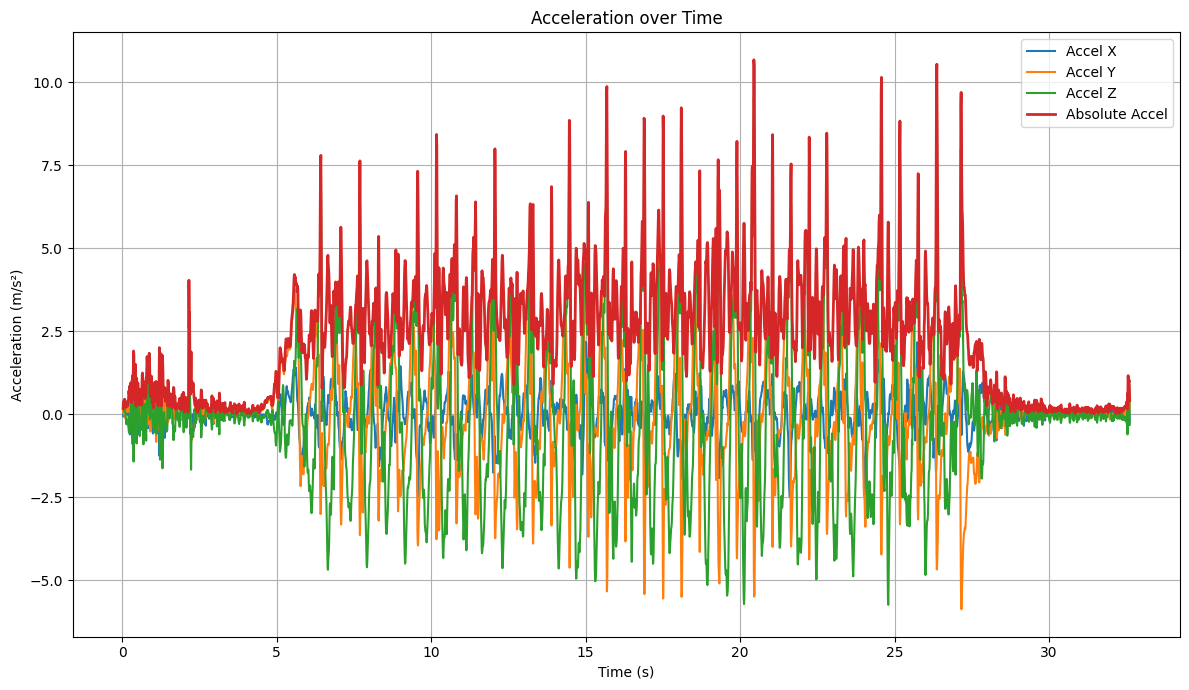

In [6]:
# Importing data and putting it in a pandas dataframe
os.chdir(folder_path)
print(os.listdir())
file_path = folder_path / "Versnelling_walking_1.csv"

df = pd.read_csv(
    file_path,
    sep=",",
    decimal=","
)

# Plot the data from the pandas dataframe
plt.figure(figsize=(12, 7))

plt.plot(df["Time (s)"], df["Linear Acceleration x (m/s^2)"], label="Accel X")
plt.plot(df["Time (s)"], df["Linear Acceleration y (m/s^2)"], label="Accel Y")
plt.plot(df["Time (s)"], df["Linear Acceleration z (m/s^2)"], label="Accel Z")
plt.plot(
    df["Time (s)"],
    df["Absolute acceleration (m/s^2)"],
    label="Absolute Accel",
    linewidth=2
)

plt.autoscale(enable=True, axis="both", tight=False) # To ensure a perfect fit 

plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Acceleration over Time")
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

#### 1.2 Preliminary work

Before we do the pace estimation we have to select an appropriate interval for analysis (1), do a preliminary estimation for pace (2) and decide whether we need a particular acceleration direction or use the total acceleration magnitude (3) .

1. Based on the plot above we select the time interval from 15 seconds untill 20 seconds. During this interval the walking pace was most steady. Every other interval with steady data would be equally valid. 

2. The average walking speed is between 4 and 6 km/h and the average step length is between 1 meter. With a speed of 5 km/h and a step length of 1 meter, we estimate the walking frequency to be around 1.8 Hz over the chosen interval.

3. The total acceleration magnitude is required as the walking data was not set in a particular direction, therefore more than one dimension needs to be taken into account.

#### 1.3 Pace estimation

Once we have that out of the way, we can start writing code to estimate the pace. We used the following method: each big acceleration peak (absolute acceleration) equals one step. The problem is: there are a lot of peaks, some small, some big. To get a valid estimate of the amount of steps we took, we have to filter the biggest peaks that in reality correspond to the steps. Our method:
- Within this interval, the absolute acceleration magnitude was computed from the three acceleration components using: amag = sqrt(ax^2 + ay^2 + az^2). This magnitude signal is used for peak detection because it combines the contributions of all three axes and is less sensitive to sensor orientation.
- Step detection was primarily based on the height of the peaks. Only peaks whose magnitude exceeded a threshold — defined as the mean acceleration plus a fraction of its standard deviation — were considered as potential steps. This ensures that small fluctuations and noise are ignored.
- In addition, a minimum time distance between consecutive peaks was applied as a secondary check. Based on typical human walking cadence (0.3–0.6 seconds per step), we enforced a minimum interval of approximately 0.4 seconds between peaks to prevent counting multiple peaks from a single step.
- The number of detected peaks that met these criteria corresponds to the estimated number of steps in the selected interval.


In [7]:
t_start = 15.0
t_end = 20.0

selected = df[ # Create the interval in the data
    (df["Time (s)"] >= t_start) &
    (df["Time (s)"] <= t_end)
].copy() 

selected["amag"] = np.sqrt(
   selected["Linear Acceleration x (m/s^2)"]**2 +
   selected["Linear Acceleration y (m/s^2)"]**2 +
   selected["Linear Acceleration z (m/s^2)"]**2
)


t = selected["Time (s)"].values
amag = selected["amag"].values


sampling_rate = 1 / np.mean(np.diff(t))  # in Hz


min_distance_sec = 0.4  # minimum interval between peaks (~0.5 s) (humans walk 0.5–1.0 s per step)
min_distance_samples = int(min_distance_sec * sampling_rate)




peaks, properties = find_peaks(
   amag,
   distance=min_distance_samples,
   height=np.mean(amag) + 0.2 * np.std(amag) # To avoid height small fluctuations
)


step_times = t[peaks]
n_steps = len(peaks) # amount of steps


duration = t[-1] - t[0]  # duration of selected interval
step_frequency_hz = n_steps / duration
step_frequency_spm = step_frequency_hz * 60  # steps per minute
step_length = 1 # Taking 1 meter per step
velocity = (1*n_steps) / duration

print(f"Interval start: {t_start}, interval end: {t_end}")
print(f"Interval duration: {duration:.2f} s")
print(f"Steps: {n_steps} ")
print(f"Step frequency: {step_frequency_hz:.2f} Hz")
print(f"Steps per minute: {step_frequency_spm:.0f} steps/min, ({(velocity *3.6):.2f} km/h) assuming 1 meter per step")

Interval start: 15.0, interval end: 20.0
Interval duration: 4.99 s
Steps: 9 
Step frequency: 1.80 Hz
Steps per minute: 108 steps/min, (6.50 km/h) assuming 1 meter per step


#### 1.4 Acceleration magnitude vs time with the detected peaks

We did the pace estimation and now it is time to plot the acceleration magnitude versus time with the detected peaks over our selected time interval. All peaks that were selected as steps will be highlighted over the chosen interval. We will create these plots using mulitple data sets. Sets where we were running and walking up steps:


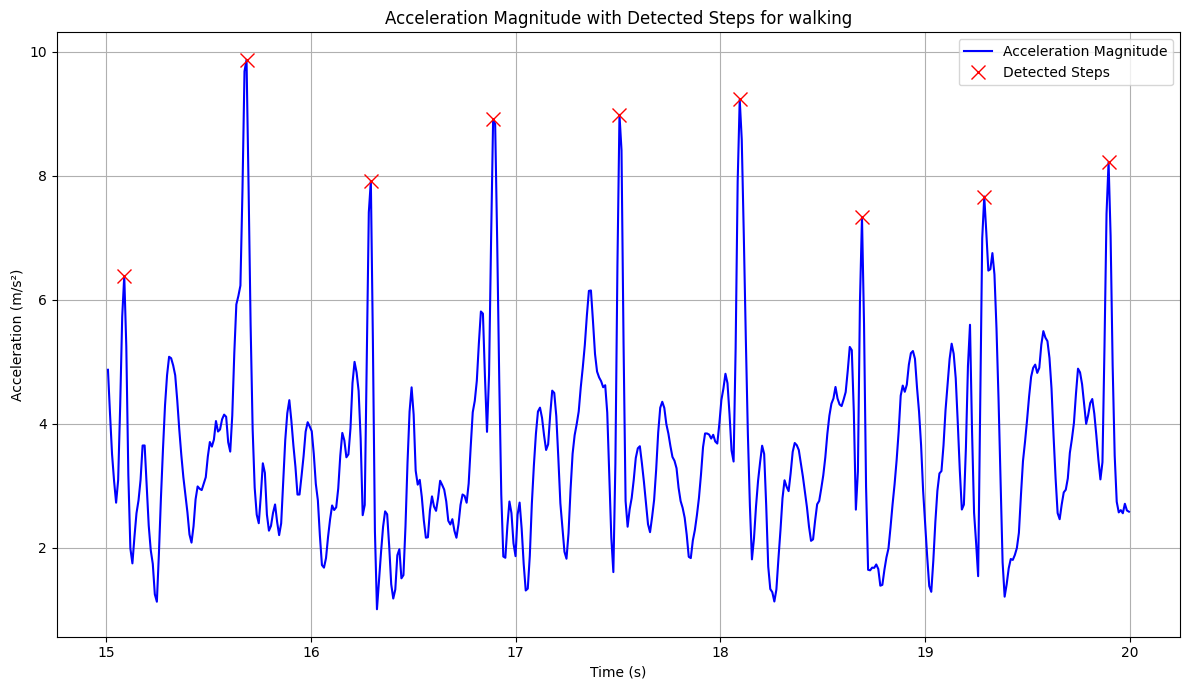

In [8]:
plt.figure(figsize=(12, 7))


plt.plot(t, amag, label="Acceleration Magnitude", color='blue')
plt.plot(step_times, amag[peaks], 'rx', label="Detected Steps", markersize=10)  # Mark peaks


plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Acceleration Magnitude with Detected Steps for walking")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 1.5 Plot of acceleration magnitude vs time with the detected peaks for different datasets
To check the plot of acceleration magnitude vs time with the detected peaks for different datasets, for example, one where we were running or walking up stairs, we copy the code and use the other data file in the directory. The only thing that we have to change is the data file where the script gets its data from. We recorded acceleration data when running and while walking up stairs.

Files in folder: ['6BBR06_Final_Assignment_2025.pdf', '.git', 'Lift_2.csv', 'Versnelling_walking_1.csv', 'Versnelling_stairs_1.csv', 'Versnelling_running_1.csv', 'CBL programming.ipynb', 'Swing_3.csv']


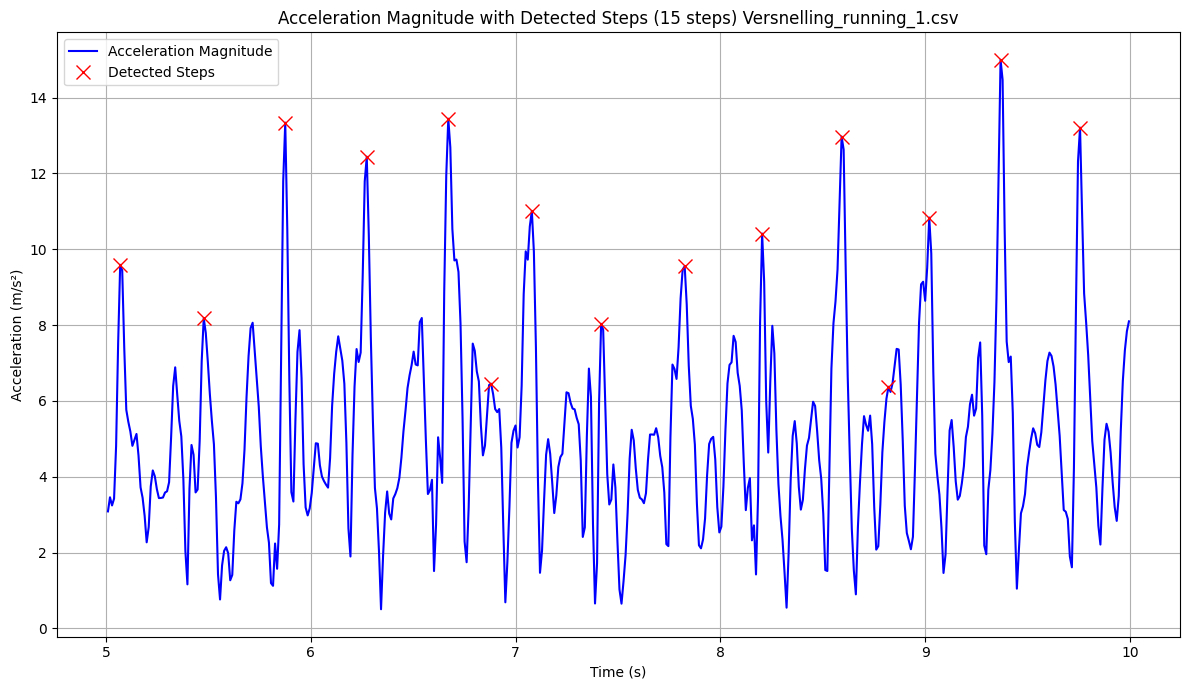

File: Versnelling_running_1.csv
Interval start: 5.0, interval end: 10.0
Interval duration: 4.99 s
Steps: 15 
Step frequency: 3.01 Hz
Steps: 180 steps/min, 10.83 km/h)

Files in folder: ['6BBR06_Final_Assignment_2025.pdf', '.git', 'Lift_2.csv', 'Versnelling_walking_1.csv', 'Versnelling_stairs_1.csv', 'Versnelling_running_1.csv', 'CBL programming.ipynb', 'Swing_3.csv']


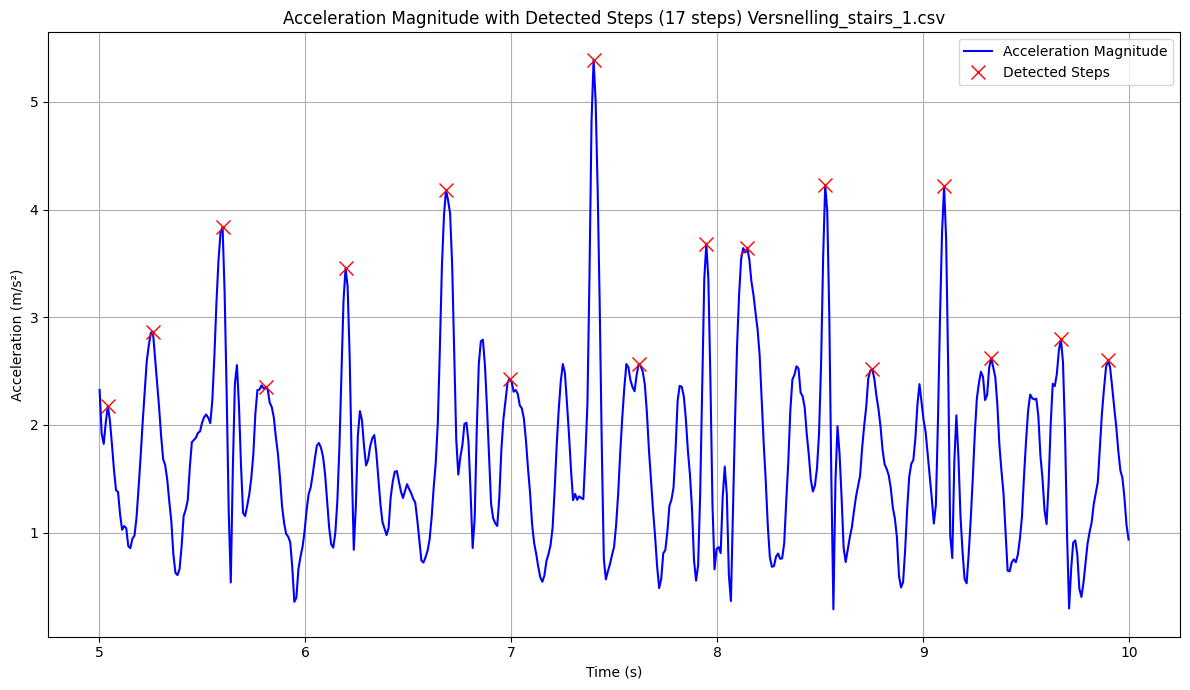

File: Versnelling_stairs_1.csv
Interval start: 5.0, interval end: 10.0
Interval duration: 5.00 s
Steps: 17 
Step frequency: 3.40 Hz
Steps: 204 steps/min, 12.25 km/h)



In [9]:
def plot_acceleration_steps(t_start, t_end, folder_path, file_path):
    print("Files in folder:", os.listdir())
    
    # Load CSV
    df = pd.read_csv(file_path, sep=",", decimal=",")
    
    # Create nterval
    selected = df[(df["Time (s)"] >= t_start) & (df["Time (s)"] <= t_end)].copy()
    
    # Compute acceleration magnitude
    selected["amag"] = np.sqrt(
        selected["Linear Acceleration x (m/s^2)"]**2 +
        selected["Linear Acceleration y (m/s^2)"]**2 +
        selected["Linear Acceleration z (m/s^2)"]**2
    )
    
    t = selected["Time (s)"].values
    amag = selected["amag"].values
    
    # Sampling rate
    sampling_rate = 1 / np.mean(np.diff(t))  # in Hz
    
    # Minimum distance between peaks
    min_distance_sec = 0.2  # humans run 0.2–0.6 s per step
    min_distance_samples = int(min_distance_sec * sampling_rate)
    
    # Find peaks
    peaks, properties = find_peaks(
        amag,
        distance=min_distance_samples,
        height=np.mean(amag) + 0.2 * np.std(amag)
    )
    
    step_times = t[peaks]
    n_steps = len(peaks)
    
    # Plot
    plt.figure(figsize=(12, 7))
    plt.plot(t, amag, label="Acceleration Magnitude", color='blue')
    plt.plot(step_times, amag[peaks], 'rx', label="Detected Steps", markersize=10)
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.title(f"Acceleration Magnitude with Detected Steps ({n_steps} steps) {file_path}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print step info
    duration = t[-1] - t[0]
    step_frequency_hz = n_steps / duration
    step_frequency_spm = step_frequency_hz * 60  # steps per minute
    step_length = 1  # assume 1 m per step
    velocity = (step_length * n_steps) / duration
    print(f"File: {file_path}")
    print(f"Interval start: {t_start}, interval end: {t_end}")
    print(f"Interval duration: {duration:.2f} s")
    print(f"Steps: {n_steps} ")
    print(f"Step frequency: {step_frequency_hz:.2f} Hz")
    print(f"Steps: {step_frequency_spm:.0f} steps/min, {(velocity *3.6):.2f} km/h)\n")

# Parameters
file_path_list = ["Versnelling_running_1.csv", "Versnelling_stairs_1.csv"] # All data sets
t_start = 5.0
t_end = 10.0

# Run
for file_path in file_path_list:
    file_path = file_path
    plot_acceleration_steps(t_start, t_end, folder_path, file_path)

When walking, the body moves gently and steadily. The acceleration peaks are few, evenly spaced, and reflect a calm, regular rhythm. Running is faster and more intense: peaks are taller, closer together, and appear more frequently, showing the quick, energetic steps. Climbing stairs tells a different story—peaks are uneven and irregular, reflecting the extra effort of lifting the body and the variable pace. Each movement leaves a distinct “signature” in the acceleration data, letting us tell walking, running, and stairs apart at a glance. 

#### 1.6 Fourier transforms and comparison with manuel peak detection

Dominant frequency from FFT: 3.20 Hz (192 steps/min)


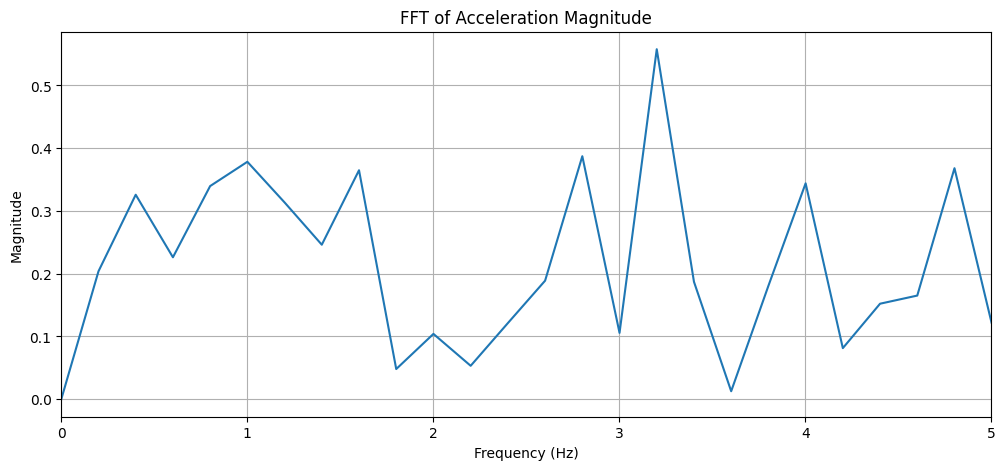

In [10]:
def fft_step_frequency(selected):
    t = selected["Time (s)"].values
    amag = selected["amag"].values

    dt = np.mean(np.diff(t))
    N = len(amag)

    # Remove DC component
    amag = amag - np.mean(amag)

    Y = fft(amag)
    Y_mag = 2.0/N * np.abs(Y[:N//2])
    freqs = fftfreq(N, dt)[:N//2]

    # Focus on human step frequencies
    valid = (freqs >= 0.5) & (freqs <= 5.0)
    dominant_freq = freqs[valid][np.argmax(Y_mag[valid])]

    print(f"Dominant frequency from FFT: {dominant_freq:.2f} Hz ({dominant_freq*60:.0f} steps/min)")

    plt.figure(figsize=(12,5))
    plt.plot(freqs, Y_mag)
    plt.xlim(0, 5)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title("FFT of Acceleration Magnitude")
    plt.grid(True)
    plt.show()

    return dominant_freq



selected = df[(df["Time (s)"] >= t_start) & (df["Time (s)"] <= t_end)].copy()
selected["amag"] = np.sqrt(
    selected["Linear Acceleration x (m/s^2)"]**2 +
    selected["Linear Acceleration y (m/s^2)"]**2 +
    selected["Linear Acceleration z (m/s^2)"]**2
)
dominant_freq = fft_step_frequency(selected)


According to the FFT, the frequency is 2.40 Hz. This does not align with our manualy found step frequency. The FFT is rougly 2 times larger. We think that this inconsistency is caused because FFT detects step harmonics, not steps. The magnitude sqrt(ax² + ay² + az²) creates two peaks per step in many cases: heel strike
and push-off. 
- Manual peak detection → step frequency
- FFT → impact frequency (≈ 2× step frequency)

This is why we can devide the FFT by two to get the accurate frequency which is: 3.4 / 2 = 1.7. This aligns with our manually found step frequency.

In [11]:
%reset -f
%store -r folder_path

## Task 2: Elevator Power Estimation

For the second task, we have to characterize the traveling velocity, floor height, and to estimate the power output of the motor of an elevator. We took interest in the lift of the apartment building Floris lives in because he takes it every day. He took the elevator from the second floor. The main things we work out in this task are:
1. Import the data into a pandas dataframe and plotting the acceleration, velocity, and position of the elevator over time
2. Analysis of plots
3. Characterize various aspects of the elevator
4. Difference with heavier load

#### 2.0 Libraries and imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

#### 2.1 Importing elevator data into pandas dataframe and plotting the acceleration, velocity, and position of the elevator over time


How the data is handled to make the three plots:
1. Acceleration
- Data source: The raw vertical acceleration (Acceleration z) measured by your phone’s accelerometer.
- Gravity correction: The raw accelerometer includes gravity (≈ 9.81 m/s²). To get actual elevator acceleration, we subtract the gravitational component.
- How gravity is estimated: We assume the elevator is stationary in the first second (t < 1.0 s). The mean acceleration during this period approximates the local 
gravitational acceleration g.
- Resulting a: This is the true elevator acceleration over time, used for plotting.
2. Velocity
- Data source: a, the acceleration obtained in the previous step.
- Integration: Velocity is the integral of acceleration over time: v(t) = ∫ a(t) dt
- Technique used: scipy.integrate.cumulative_trapezoid performs cumulative trapezoidal integration, giving velocity as a function of time rather than just the total change.
- Drift correction: Numerical integration can accumulate small errors (drift). We subtract a linear trend so that the final velocity returns to zero (elevator stops at the last floor).
3. Position
- Data source: v, the velocity computed in the previous step.
- Integration: Position is the integral of velocity over time: v(t) = ∫ a(t) dt
- Technique used: Again, cumulative_trapezoid for cumulative integration over time, giving position as a function of time.
- Resulting x: Represents elevator height above starting floor at each time step.


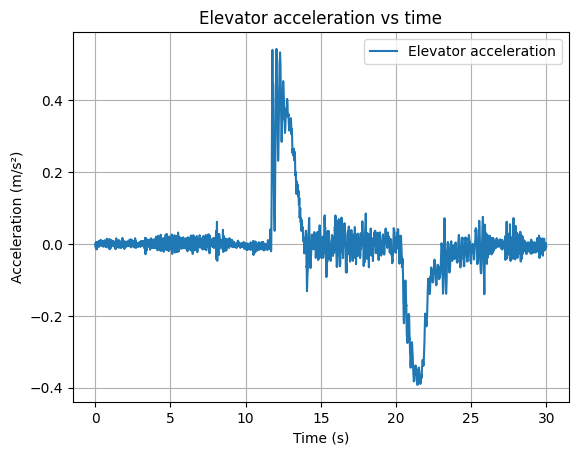

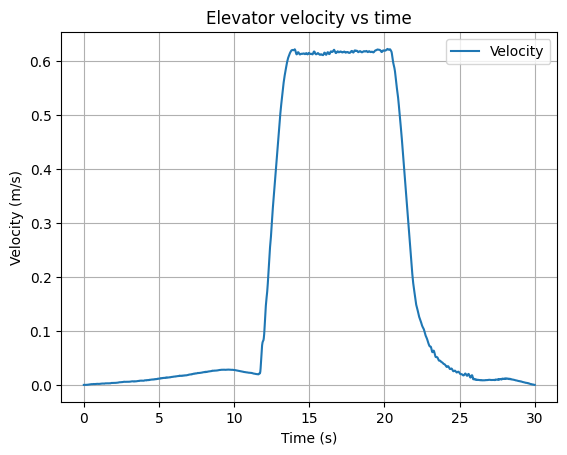

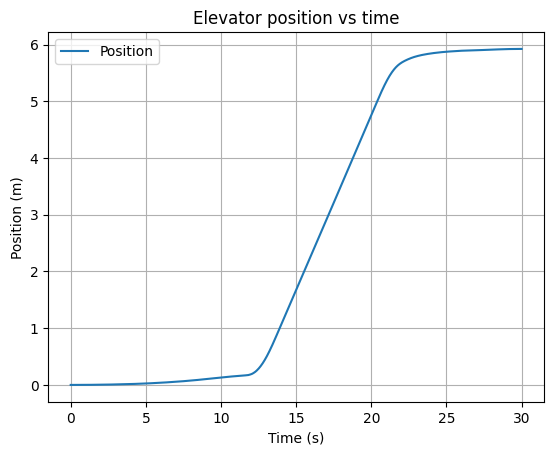

In [13]:
# Import data into pandas dataframe
df = pd.read_csv(
    "Lift_2.csv",
    sep=",",
    decimal=",", # important: comma decimal separator
    quotechar='"'
)

df = df.apply(pd.to_numeric, errors="coerce") # Convert all columns to float (safe cleanup)
df = df[df["Time (s)"] < 30]

# Plot acceleration
t = df["Time (s)"].values
az = df["Acceleration z (m/s^2)"].values

g = np.mean(az[t < 1.0]) # Estimate gravity from stationary part (first second)
a = az - g # Elevator acceleration (remove gravity)

plt.figure()
plt.plot(t, a, label="Elevator acceleration")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Elevator acceleration vs time")
plt.grid()
plt.legend()
plt.show()



# Plot velocity
v = cumulative_trapezoid(a, t, initial=0)
v -= np.linspace(0, v[-1], len(v))

plt.figure()
plt.plot(t, v, label="Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Elevator velocity vs time")
plt.grid()
plt.legend()
plt.show()

# position of elevator over time
x = cumulative_trapezoid(v, t, initial=0)

plt.figure()
plt.plot(t, x, label="Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Elevator position vs time")
plt.grid()
plt.legend()
plt.show()

#### 2.2 Analysis of plots

1. Acceleration:
The elevator shows a sharp acceleration peak at start and stop, indicating motor-controlled motion, while the acceleration remains near zero during cruising, reflecting constant speed and smooth, comfort-oriented operation.
2. Velocity:
Velocity rises linearly during the acceleration phase, reaches a plateau during cruising, and decreases symmetrically during braking, illustrating controlled start and stop.
3. Position
Position increases steadily with time, showing upward travel. The final position is at around 6 meter, this is a normal height for a second floor .

#### 2.3 Characterize various aspects of the elevator

In this part, we will calculate various aspects of the elevator like: the Total travel time, Total vertical displacement, Maximum velocity, Mean cruising velocity, Mean motor power, Peak motor power

In [14]:
# Characterize drive
m = 75  # The total mass in the elevator

travel_time = t[-1] - t[0]
total_height = x[-1]
max_speed = np.max(v)
v_threshold = 0.05  
mean_speed = np.mean(v[v > v_threshold])  # ignore near-zero values 


# Power: P = m (g + a) v
P = m * (g + a) * v

peak_power = np.max(P)

print("\n--- Elevator Drive Characterization ---")
print(f"Total travel time: {travel_time:.2f} s")
print(f"Total vertical displacement: {total_height:.2f} m")
print(f"Maximum velocity: {max_speed:.2f} m/s")
print(f"Mean cruising velocity: {mean_speed:.2f} m/s")

print("\n--- Motor Power ---")
print(f"Mean motor power: {np.mean(P[np.abs(v) > v_threshold]):.1f} W")
print(f"Peak motor power: {peak_power:.1f} W")


--- Elevator Drive Characterization ---
Total travel time: 30.00 s
Total vertical displacement: 5.92 m
Maximum velocity: 0.62 m/s
Mean cruising velocity: 0.48 m/s

--- Motor Power ---
Mean motor power: 353.0 W
Peak motor power: 457.1 W


#### 2.4 Difference with heavier load

For a heavier load inside the elevator, the acceleration and velocity profiles are expected to remain largely unchanged, since elevator motion is primarily constrained by passenger comfort and safety requirements. However, the motor force required to lift the elevator increases with the total mass. As a result, the motor power, given by 
𝑃 = 𝑚(𝑔 + 𝑎)𝑣, scales approximately linearly with the load mass. This leads to a higher average and peak motor power for heavier loads, while the travel time and maximum velocity remain approximately constant. Consequently, heavier loads place greater mechanical and electrical demand on the elevator motor without significantly altering the overall motion profile.

In [15]:
%reset -f
%store -r folder_path

## Task 3 Damped Oscillation on a Swing

In the third experiment, we are giong to measure the motion of a swing as it slows down and extract the damping ratio by fitting a mathematical model for data. We measured the acceleration and the length of the swing.....


We be doing the following tasks:
1. Import the data into a pandas dataframe and plotting the acceleration
2. Fitting the analytical model to our measured data and estimate ω0 and ζ
3. Compare the fitted ω0 to the theoretical value √(g/L)

#### 3.0 Libraries and imports

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#### 3.1 Import the data into a pandas dataframe and plotting the acceleration

The first step is to import and plot the data so we can inspect the data before using it. From the plot we see can conclude that we have to use the absolute acceleration because the acceleration went it all directions. We also observe that the swing comes to rest at an acceleration of a little bit less than 10 m/s^2 used by the gravitational acceleration 'g'.

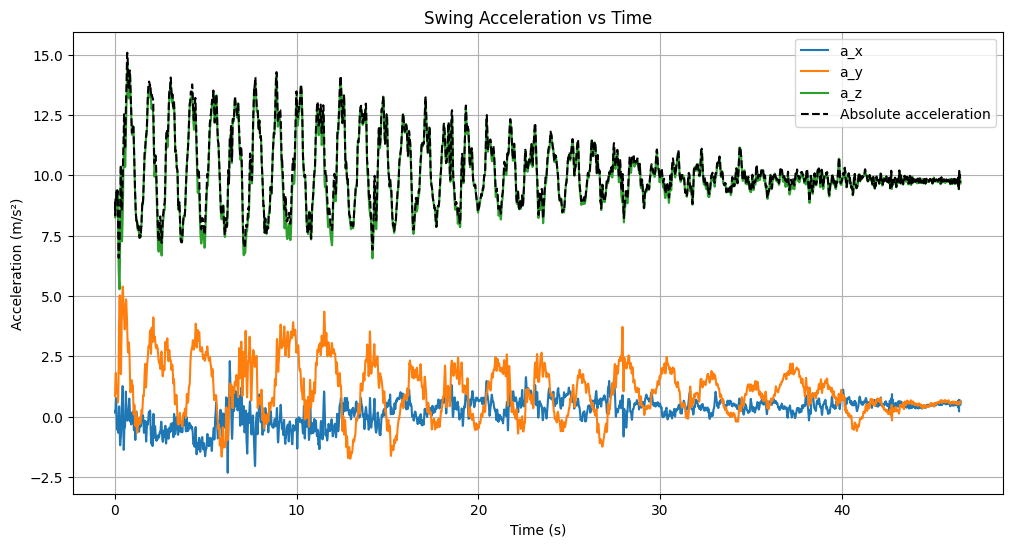

In [17]:
# Load your data
df = pd.read_csv(
    "Swing_3.csv",
    sep=",",
    decimal=","
)

df = df.apply(pd.to_numeric, errors="coerce")

t = df["Time (s)"].values
a_x = df["Acceleration x (m/s^2)"].values
a_y = df["Acceleration y (m/s^2)"].values
a_z = df["Acceleration z (m/s^2)"].values
a_abs = df["Absolute acceleration (m/s^2)"].values

# Plot raw accelerations
plt.figure(figsize=(12, 6))
plt.plot(t, a_x, label="a_x")
plt.plot(t, a_y, label="a_y")
plt.plot(t, a_z, label="a_z")
plt.plot(t, a_abs, label="Absolute acceleration", linestyle="--", color="k")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Swing Acceleration vs Time")
plt.legend()
plt.grid(True)
plt.show()


#### 3.2 Fitting the analytical model to our measured data and estimate ω0 and ζ



1. The acceleration data were imported from the CSV file and converted to numerical values.
2. The absolute acceleration was selected since the motion occurs in multiple directions.
3. The gravitational acceleration was estimated from the mean acceleration at the end of the measurement and subtracted to obtain the dynamic acceleration.
4. The swing motion was modeled as a damped harmonic oscillator with an exponentially decaying cosine function.
5. Initial guesses for the model parameters were chosen based on the observed oscillation frequency and damping.
6. A nonlinear least-squares fit was performed to estimate the natural angular frequency and damping ratio. 
7. The fitted model was plotted together with the measured data to verify agreement.


8. The swing length was estimated from the fitted natural frequency using 
𝐿 = 𝑔 / (𝜔0)^2.

The first step is to import and plot the data so we can inspect the data before using it. From the plot we see can conclude that we have to use the absolute acceleration because the acceleration went it all directions. We also observe that the swing comes to rest at an acceleration of a little bit less than 10 m/s^2 used by the gravitational acceleration 'g'.

Estimated natural angular frequency ω0 = 5.397 rad/s
Estimated damping ratio ζ = 0.0097
Estimated swing length L = 0.3368


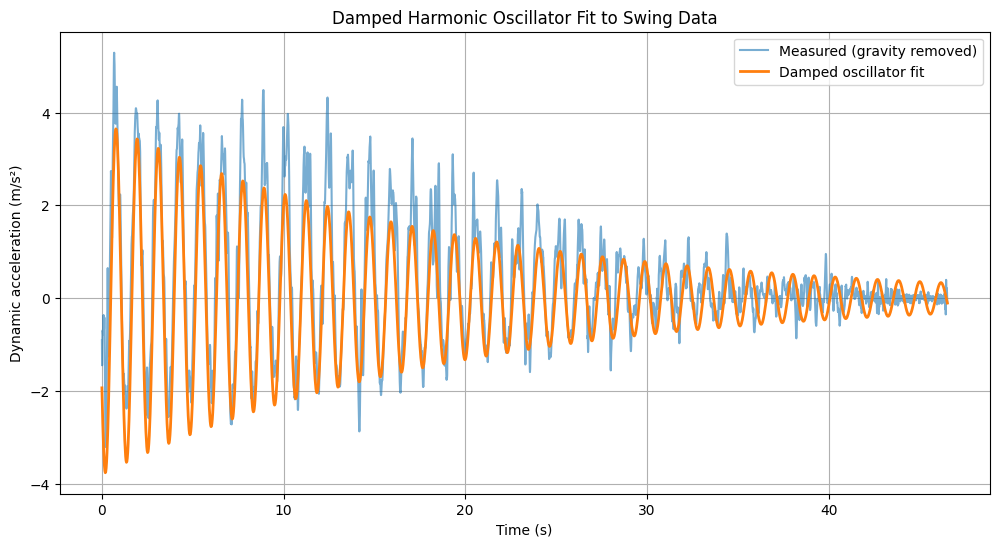

In [18]:
# Load data
df = pd.read_csv("Swing_3.csv", sep=",", decimal=",")
df = df.apply(pd.to_numeric, errors="coerce")

t = df["Time (s)"].values
a_abs = df["Absolute acceleration (m/s^2)"].values

# Remove gravity offset (use mean of last few seconds)
g_est = np.mean(a_abs[-200:])
a_dyn = a_abs - g_est


def damped_acceleration(t, A, omega0, zeta, phi):
    omega_d = omega0 * np.sqrt(1 - zeta**2)
    return A * np.exp(-zeta * omega0 * t) * np.cos(omega_d * t + phi)

# Initial guesses
A0 = np.max(np.abs(a_dyn))
omega0_0 = 2 * np.pi * 0.5 # 0.5 Hz swing frequency
zeta_0 = 0.05 # light damping
phi_0 = 0

p0 = [A0, omega0_0, zeta_0, phi_0]

# Fit
params, covariance = curve_fit(
    damped_acceleration,
    t,
    a_dyn,
    p0=p0
)

A_fit, omega0_fit, zeta_fit, phi_fit = params

print(f"Estimated natural angular frequency ω0 = {omega0_fit:.3f} rad/s")
print(f"Estimated damping ratio ζ = {zeta_fit:.4f}")

L_est = 9.81 / omega0_fit**2 
print(f"Estimated swing length L = {L_est:.4f}")

t_fit = np.linspace(t[0], t[-1], 2000)
a_fit = damped_acceleration(t_fit, *params)

plt.figure(figsize=(12,6))
plt.plot(t, a_dyn, label="Measured (gravity removed)", alpha=0.6)
plt.plot(t_fit, a_fit, label="Damped oscillator fit", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Dynamic acceleration (m/s²)")
plt.title("Damped Harmonic Oscillator Fit to Swing Data")
plt.legend()
plt.grid(True)
plt.show()


- The swing behaves like a lightly damped harmonic oscillator
- The decay envelope gives ζ
- The oscillation frequency gives ω₀
- From ω₀ you can estimate the swing length L, which is equal to 0.34 meters. This aligns with our measurements.
- The fact that acceleration settles near g confirms correct physical behavior
- The positive acceleration is caused by aerodynamics of the person swinging 

#### 3.3 Compare the fitted ω0 to the theoretical value √(g/L)

Fitted ω0 = 5.397 rad/s
Theoretical ω0 = 5.371 rad/s
Relative difference = 0.47 %


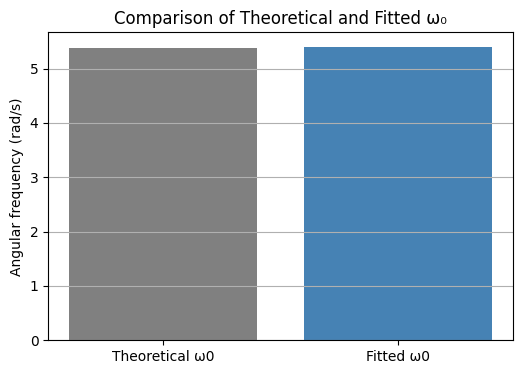

In [19]:
g = 9.81  # m/s^2
L = 0.34  # measured swing length in meters

omega0_theory = np.sqrt(g / L)

omega0_fit  

relative_error = abs(omega0_fit - omega0_theory) / omega0_theory * 100

print(f"Fitted ω0 = {omega0_fit:.3f} rad/s")
print(f"Theoretical ω0 = {omega0_theory:.3f} rad/s")
print(f"Relative difference = {relative_error:.2f} %")




labels = ["Theoretical ω0", "Fitted ω0"]
values = [omega0_theory, omega0_fit]

plt.figure(figsize=(6,4))
plt.bar(labels, values, color=["gray", "steelblue"])
plt.ylabel("Angular frequency (rad/s)")
plt.title("Comparison of Theoretical and Fitted ω₀")
plt.grid(axis="y")
plt.show()



In [20]:
%reset -f
%store -r folder_path

## Task 4 ???